# Project 5: Classifying Point Clouds with PointNet

For this project, we are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

Basic learning objectives of this project:
* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

In [2]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = False
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Apple Silicon GPU detected. Consider setting use_apple_silicon to True.
Using device: cpu


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [3]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).

**TODO 1:** complete `part1_dataloader.py`

In [20]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

In [21]:
print("test_dataset_length(): ", verify(test_dataset_length))
print("test_unique_values(): ", verify(test_unique_values))
print("test_get_points_from_file(): ", verify(test_get_points_from_file))
print("test_pad_points(): ", verify(test_pad_points))
print("test_class_values(): ", verify(test_class_values))

test_dataset_length():  "Correct"
test_unique_values():  "Correct"
test_get_points_from_file():  "Correct"
test_pad_points():  "Correct"
test_class_values():  "Correct"


Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [22]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

For more details see the project pdf.

**TODO 2:** complete `part2_baseline.py`

In [23]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [24]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


Lets train our baseline implementation and see how it does! Fill in the hyperparameters and train your model. 

To get full credit for this section, you will need *$\geq$ 30%* accuracy on the test data set. The TAs were able to consistently achieve this accuracy with ~15 epochs.

*Hint: Play around with different voxel resolutions and the two different modes you implemented to see which configuration works the best.*

In [25]:
lr = 0.05
weight_decay = 1e-4
epochs = 10

model = Baseline(20, voxel_resolution=8, mode="occupancy")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [26]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|██████████| 213/213 [00:01<00:00, 175.80it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 138.67it/s]



Epoch 1 Stats:
	Training accuracy: 0.5447
	Training loss: 1.5138
	Validation accuracy: 0.4567
	Validation loss: 2.3569

Validation accuracy improved from 0 to 0.4566666781902313
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:00<00:00, 305.78it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 335.74it/s]



Epoch 2 Stats:
	Training accuracy: 0.6629
	Training loss: 1.0410
	Validation accuracy: 0.4317
	Validation loss: 2.4199


Epoch 3

Training...


100%|██████████| 213/213 [00:00<00:00, 286.66it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 259.41it/s]



Epoch 3 Stats:
	Training accuracy: 0.6847
	Training loss: 0.9570
	Validation accuracy: 0.4483
	Validation loss: 2.7913


Epoch 4

Training...


100%|██████████| 213/213 [00:00<00:00, 284.33it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 329.26it/s]



Epoch 4 Stats:
	Training accuracy: 0.6888
	Training loss: 0.8904
	Validation accuracy: 0.4817
	Validation loss: 2.3905

Validation accuracy improved from 0.4566666781902313 to 0.4816666543483734
Saving model to Baseline.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:00<00:00, 229.02it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 60.52it/s] 



Epoch 5 Stats:
	Training accuracy: 0.6985
	Training loss: 0.8972
	Validation accuracy: 0.5217
	Validation loss: 2.4804

Validation accuracy improved from 0.4816666543483734 to 0.5216666460037231
Saving model to Baseline.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:01<00:00, 130.40it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 115.40it/s]



Epoch 6 Stats:
	Training accuracy: 0.7041
	Training loss: 0.9059
	Validation accuracy: 0.4750
	Validation loss: 2.7493


Epoch 7

Training...


100%|██████████| 213/213 [00:00<00:00, 264.65it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 266.96it/s]



Epoch 7 Stats:
	Training accuracy: 0.7012
	Training loss: 0.8711
	Validation accuracy: 0.4533
	Validation loss: 2.7695


Epoch 8

Training...


100%|██████████| 213/213 [00:00<00:00, 300.35it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 338.51it/s]



Epoch 8 Stats:
	Training accuracy: 0.7144
	Training loss: 0.8467
	Validation accuracy: 0.4617
	Validation loss: 2.8570


Epoch 9

Training...


100%|██████████| 213/213 [00:00<00:00, 216.24it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 216.85it/s]



Epoch 9 Stats:
	Training accuracy: 0.6950
	Training loss: 0.9139
	Validation accuracy: 0.4900
	Validation loss: 2.9474


Epoch 10

Training...


100%|██████████| 213/213 [00:00<00:00, 220.34it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 336.49it/s]


Epoch 10 Stats:
	Training accuracy: 0.7003
	Training loss: 0.8980
	Validation accuracy: 0.4867
	Validation loss: 2.7673




In [27]:
model = torch.load('output/Baseline.pt')
test_acc, test_loss = test(model, test_loader)

/var/folders/b1/z_trb9ts60d83t6x0mqhn4j00000gp/T/ipykernel_56406/2856288945.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 188.65it

Test accuracy: 0.5217
Test loss: 2.4875


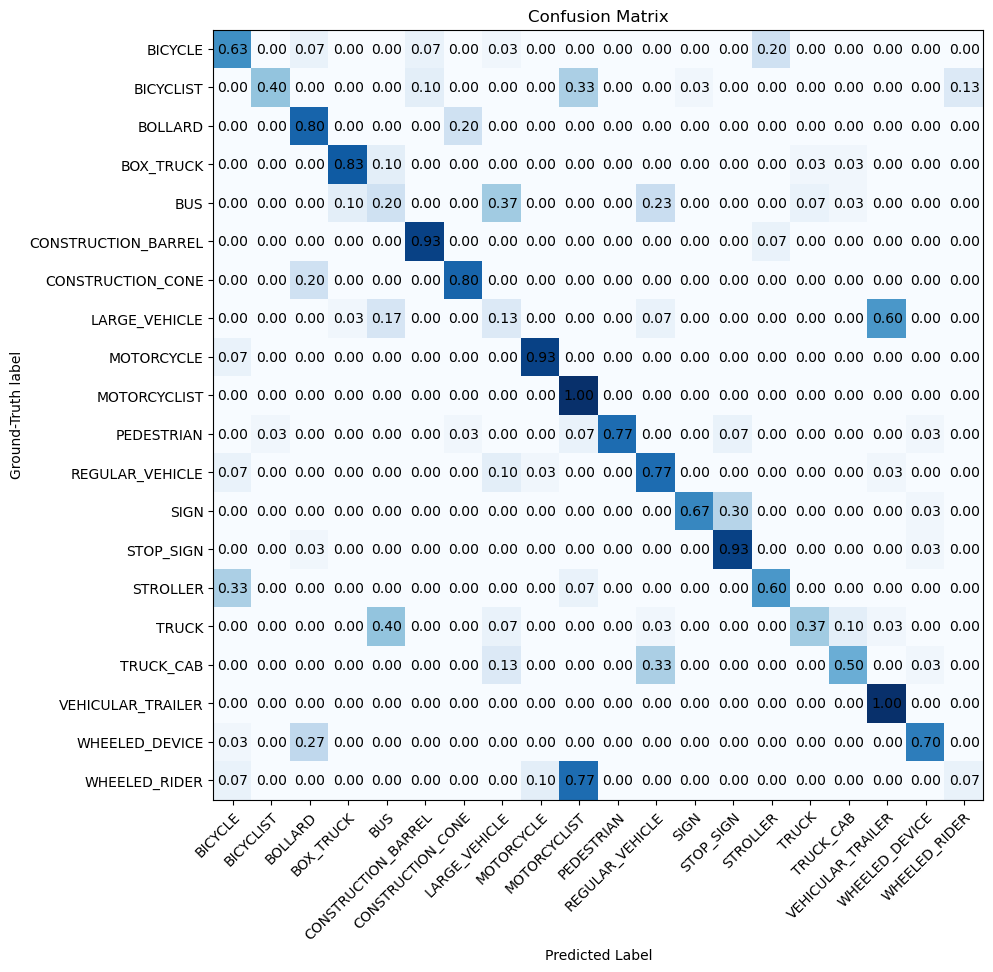

In [85]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
generate_and_plot_confusion_matrix(model, test_loader, 20)

## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well. For an architecture diagram of what we will be implementing, check the project pdf.

**TODO 3**: complete `part3_pointnet.py`, use the architecture diagram in the project pdf for reference.

In [37]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [38]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


Now that we have a PointNet implementation, lets train our model and see how it does. Fill in the hyper-parameters and give your new model a spin! 

To get full credit for this section, you will need *$\geq$ 60% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~15 epochs of training.

In [39]:
lr = 0.001
weight_decay = 1e-4
epochs = 10

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [40]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:06<00:00, 32.45it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 78.08it/s]



Epoch 1 Stats:
	Training accuracy: 0.3138
	Training loss: 2.0308
	Validation accuracy: 0.3900
	Validation loss: 1.8581

Validation accuracy improved from 0 to 0.38999998569488525
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:06<00:00, 33.25it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 69.56it/s]



Epoch 2 Stats:
	Training accuracy: 0.5238
	Training loss: 1.3977
	Validation accuracy: 0.4817
	Validation loss: 1.7680

Validation accuracy improved from 0.38999998569488525 to 0.4816666543483734
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:05<00:00, 36.91it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 92.76it/s]



Epoch 3 Stats:
	Training accuracy: 0.6168
	Training loss: 1.1400
	Validation accuracy: 0.5333
	Validation loss: 1.5719

Validation accuracy improved from 0.4816666543483734 to 0.5333333611488342
Saving model to PointNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:05<00:00, 37.27it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 89.55it/s]



Epoch 4 Stats:
	Training accuracy: 0.6603
	Training loss: 0.9893
	Validation accuracy: 0.5783
	Validation loss: 1.3324

Validation accuracy improved from 0.5333333611488342 to 0.57833331823349
Saving model to PointNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:05<00:00, 37.60it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 85.41it/s]



Epoch 5 Stats:
	Training accuracy: 0.6806
	Training loss: 0.9537
	Validation accuracy: 0.4783
	Validation loss: 1.8489


Epoch 6

Training...


100%|██████████| 213/213 [00:05<00:00, 37.60it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 89.05it/s]



Epoch 6 Stats:
	Training accuracy: 0.7153
	Training loss: 0.8312
	Validation accuracy: 0.5617
	Validation loss: 1.4260


Epoch 7

Training...


100%|██████████| 213/213 [00:05<00:00, 36.85it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 84.93it/s]



Epoch 7 Stats:
	Training accuracy: 0.7429
	Training loss: 0.7392
	Validation accuracy: 0.5600
	Validation loss: 1.3650


Epoch 8

Training...


100%|██████████| 213/213 [00:05<00:00, 36.99it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 88.85it/s]



Epoch 8 Stats:
	Training accuracy: 0.7571
	Training loss: 0.7184
	Validation accuracy: 0.5750
	Validation loss: 1.3009


Epoch 9

Training...


100%|██████████| 213/213 [00:05<00:00, 37.32it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 91.01it/s]



Epoch 9 Stats:
	Training accuracy: 0.7956
	Training loss: 0.6262
	Validation accuracy: 0.5950
	Validation loss: 1.3601

Validation accuracy improved from 0.57833331823349 to 0.5950000286102295
Saving model to PointNet.pt


Epoch 10

Training...


100%|██████████| 213/213 [00:05<00:00, 37.64it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 91.81it/s]


Epoch 10 Stats:
	Training accuracy: 0.7768
	Training loss: 0.6753
	Validation accuracy: 0.6333
	Validation loss: 1.2864

Validation accuracy improved from 0.5950000286102295 to 0.6333333253860474
Saving model to PointNet.pt




In [41]:
model = torch.load('output/PointNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

/var/folders/b1/z_trb9ts60d83t6x0mqhn4j00000gp/T/ipykernel_56406/2270301145.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:00<00:00, 60.14it/

Test accuracy: 0.6333
Test loss: 1.3039


## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

**TODO 4:** complete `part4_analysis.py`

In [44]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [45]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


Lets use the confusion matrix to look at which mistakes our model is making most often.

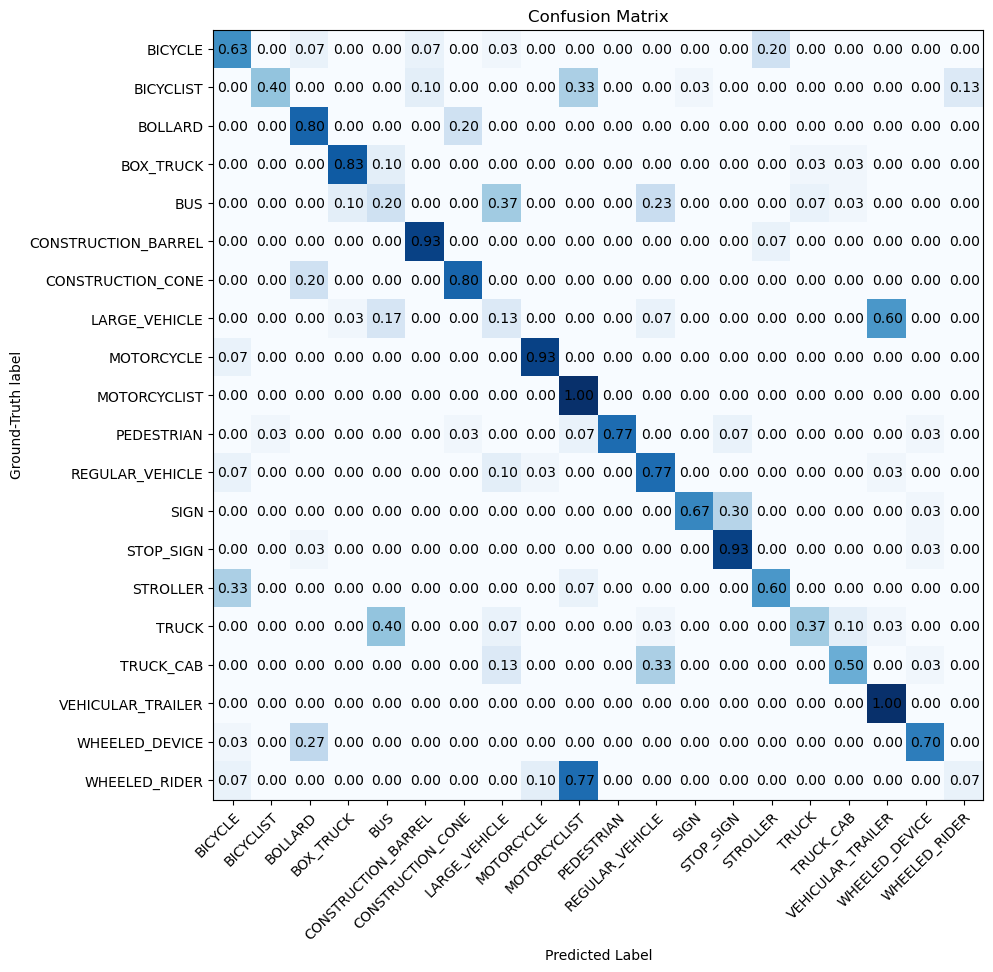

In [84]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

Now lets visualize the critical points calculated by our model for the predestrian clouds from before. Recall that these are the points that contributed to the global feature. Why do you think these were the critical points the model ended up using? (Feel free to use different point clouds for your analysis)

In [ ]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)

## Part 5: T-Net

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

**TODO 5:** complete `part5_tnet.py`

In [77]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [78]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


Let's check out how our model performs now that we added a T-Net.

To get full credit for this section, you will need *$\geq$ 65% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~10 epochs of training.

*Hint: You may need to play around with the number of layers in the T-Net*

In [79]:
lr = 0.0005
weight_decay = 5e-5
epochs = 20

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [80]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:19<00:00, 10.68it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.00it/s]



Epoch 1 Stats:
	Training accuracy: 0.2368
	Training loss: 2.1616
	Validation accuracy: 0.3017
	Validation loss: 1.8216

Validation accuracy improved from 0 to 0.3016666769981384
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:19<00:00, 10.96it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.57it/s]



Epoch 2 Stats:
	Training accuracy: 0.4918
	Training loss: 1.4742
	Validation accuracy: 0.4067
	Validation loss: 1.7006

Validation accuracy improved from 0.3016666769981384 to 0.40666666626930237
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:18<00:00, 11.22it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.85it/s]



Epoch 3 Stats:
	Training accuracy: 0.5994
	Training loss: 1.1496
	Validation accuracy: 0.4600
	Validation loss: 1.4992

Validation accuracy improved from 0.40666666626930237 to 0.46000000834465027
Saving model to PointNetTNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:19<00:00, 10.92it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.48it/s]



Epoch 4 Stats:
	Training accuracy: 0.6571
	Training loss: 1.0059
	Validation accuracy: 0.5833
	Validation loss: 1.1527

Validation accuracy improved from 0.46000000834465027 to 0.5833333134651184
Saving model to PointNetTNet.pt


Epoch 5

Training...


100%|██████████| 213/213 [00:19<00:00, 11.17it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.39it/s]



Epoch 5 Stats:
	Training accuracy: 0.6976
	Training loss: 0.9008
	Validation accuracy: 0.5483
	Validation loss: 1.3798


Epoch 6

Training...


100%|██████████| 213/213 [00:18<00:00, 11.23it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.05it/s]



Epoch 6 Stats:
	Training accuracy: 0.7562
	Training loss: 0.7455
	Validation accuracy: 0.6183
	Validation loss: 1.3212

Validation accuracy improved from 0.5833333134651184 to 0.6183333396911621
Saving model to PointNetTNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:19<00:00, 11.02it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.86it/s]



Epoch 7 Stats:
	Training accuracy: 0.7779
	Training loss: 0.6811
	Validation accuracy: 0.5800
	Validation loss: 1.2557


Epoch 8

Training...


100%|██████████| 213/213 [00:19<00:00, 10.84it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.56it/s]



Epoch 8 Stats:
	Training accuracy: 0.7938
	Training loss: 0.6269
	Validation accuracy: 0.5750
	Validation loss: 1.2381


Epoch 9

Training...


100%|██████████| 213/213 [00:18<00:00, 11.25it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.30it/s]



Epoch 9 Stats:
	Training accuracy: 0.8085
	Training loss: 0.5789
	Validation accuracy: 0.5783
	Validation loss: 1.3736


Epoch 10

Training...


100%|██████████| 213/213 [00:19<00:00, 11.10it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.14it/s]



Epoch 10 Stats:
	Training accuracy: 0.8276
	Training loss: 0.5202
	Validation accuracy: 0.6400
	Validation loss: 1.1524

Validation accuracy improved from 0.6183333396911621 to 0.6399999856948853
Saving model to PointNetTNet.pt


Epoch 11

Training...


100%|██████████| 213/213 [00:18<00:00, 11.37it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.96it/s]



Epoch 11 Stats:
	Training accuracy: 0.8244
	Training loss: 0.5226
	Validation accuracy: 0.5933
	Validation loss: 1.4161


Epoch 12

Training...


100%|██████████| 213/213 [00:19<00:00, 10.97it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.76it/s]



Epoch 12 Stats:
	Training accuracy: 0.8506
	Training loss: 0.4288
	Validation accuracy: 0.6383
	Validation loss: 1.0811


Epoch 13

Training...


100%|██████████| 213/213 [00:18<00:00, 11.35it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.22it/s]



Epoch 13 Stats:
	Training accuracy: 0.8688
	Training loss: 0.3923
	Validation accuracy: 0.5950
	Validation loss: 1.3638


Epoch 14

Training...


100%|██████████| 213/213 [00:19<00:00, 10.92it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.89it/s]



Epoch 14 Stats:
	Training accuracy: 0.8588
	Training loss: 0.4131
	Validation accuracy: 0.6083
	Validation loss: 1.5605


Epoch 15

Training...


100%|██████████| 213/213 [00:19<00:00, 10.84it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.58it/s]



Epoch 15 Stats:
	Training accuracy: 0.8700
	Training loss: 0.3723
	Validation accuracy: 0.5933
	Validation loss: 1.7061


Epoch 16

Training...


100%|██████████| 213/213 [00:19<00:00, 11.02it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.11it/s]



Epoch 16 Stats:
	Training accuracy: 0.8768
	Training loss: 0.3639
	Validation accuracy: 0.6000
	Validation loss: 1.3345


Epoch 17

Training...


100%|██████████| 213/213 [00:18<00:00, 11.27it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.57it/s]



Epoch 17 Stats:
	Training accuracy: 0.8821
	Training loss: 0.3413
	Validation accuracy: 0.6517
	Validation loss: 1.1869

Validation accuracy improved from 0.6399999856948853 to 0.6516666412353516
Saving model to PointNetTNet.pt


Epoch 18

Training...


100%|██████████| 213/213 [00:18<00:00, 11.38it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 28.08it/s]



Epoch 18 Stats:
	Training accuracy: 0.8924
	Training loss: 0.3184
	Validation accuracy: 0.6033
	Validation loss: 1.6071


Epoch 19

Training...


100%|██████████| 213/213 [00:20<00:00, 10.50it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 24.82it/s]



Epoch 19 Stats:
	Training accuracy: 0.8912
	Training loss: 0.3209
	Validation accuracy: 0.6033
	Validation loss: 1.6586


Epoch 20

Training...


100%|██████████| 213/213 [00:20<00:00, 10.47it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 27.01it/s]



Epoch 20 Stats:
	Training accuracy: 0.8926
	Training loss: 0.3293
	Validation accuracy: 0.6117
	Validation loss: 1.3794




In [81]:
model = torch.load('output/PointNetTNet.pt', map_location='cpu')
test_acc, test_loss = test(model, test_loader)

/var/folders/b1/z_trb9ts60d83t6x0mqhn4j00000gp/T/ipykernel_56406/4218532974.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 38/38 [00:01<00:00, 21.05it/

Test accuracy: 0.6517
Test loss: 1.1752


Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model. Which classes does the positional encoding help the most with? Which ones does it not really seem to make much of a difference for? Why?

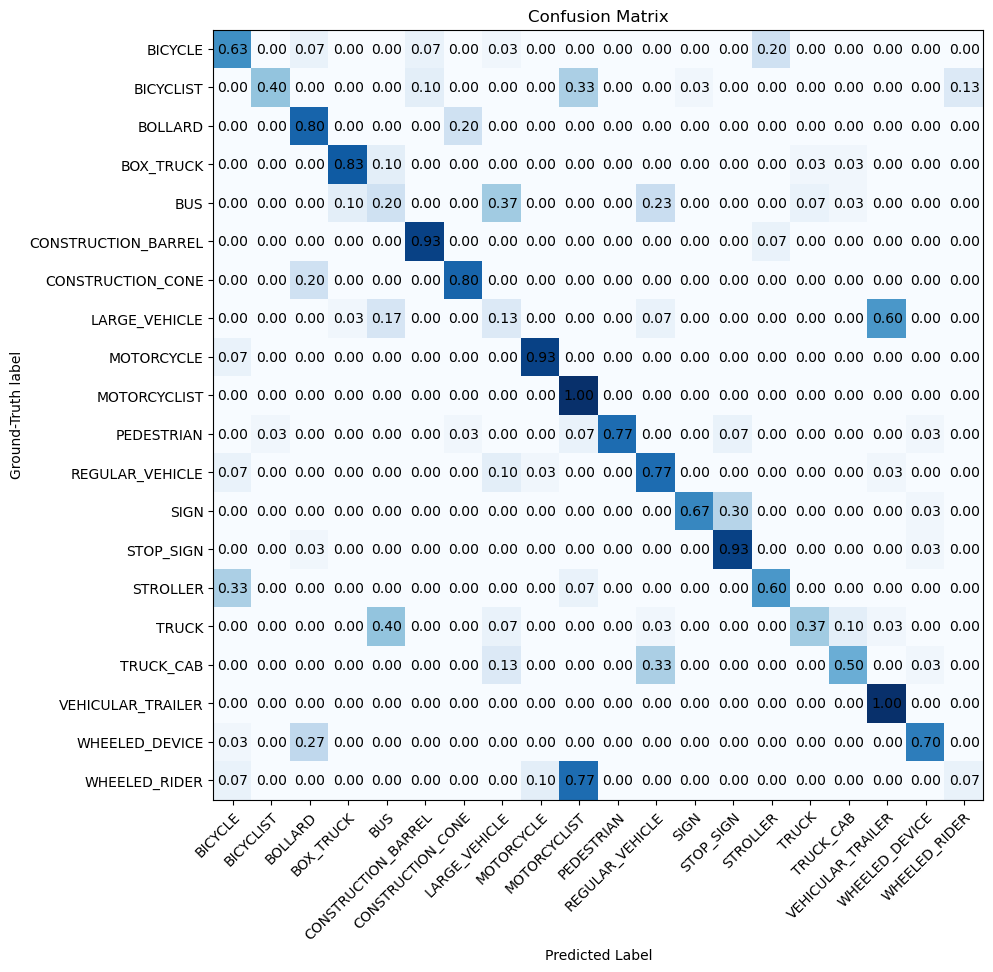

In [82]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [83]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)